In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import os
import random
import shutil
from math import ceil, sqrt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory paths
train_dir = '/content/drive/MyDrive/FYP/Datasets/train'
val_dir = '/content/drive/MyDrive/FYP/Datasets/valid'
test_dir = '/content/drive/MyDrive/FYP/Datasets/test'

# Function to identify classes in a directory
def get_classes(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

# Get the classes
classes = get_classes(train_dir)

print(f"Detected classes: {classes}")

Detected classes: ['Gangrene ', 'Acanthosis Nigricans']


In [ ]:


# Create train set
training_images= []
for cls in classes:
    cls_dir = os.path.join(train_dir, cls)
    training_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])


# Create validation set
validation_images = []
for cls in classes:
    cls_dir = os.path.join(val_dir, cls)
    validation_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])



# Create test set
test_images = []
for cls in classes:
    cls_dir = os.path.join(test_dir, cls)
    test_images.extend([os.path.join(cls_dir, img) for img in os.listdir(cls_dir)])



# Print statistics
#print(f"Total images: {len(all_images)}")
print(f"Training images: {len(training_images)}")
print(f"Validation images: {len(validation_images)}")
print(f"Test images: {len(test_images)}")

Training images: 1115
Validation images: 790
Test images: 708


In [ ]:
# Ensure no overlap between datasets
training_set = set(training_images)
validation_set = set(validation_images)
test_set = set(test_images)

# Check for overlaps
assert len(training_set & validation_set) == 0, "Overlap between training and validation sets!"
assert len(training_set & test_set) == 0, "Overlap between training and test sets!"
assert len(validation_set & test_set) == 0, "Overlap between validation and test sets!"

# Check for overlaps and print messages
if len(training_set & validation_set) > 0:
    print("Overlap found between training and validation sets!")
else:
    print("No overlap between training and validation sets.")

if len(training_set & test_set) > 0:
    print("Overlap found between training and test sets!")
else:
    print("No overlap between training and test sets.")

if len(validation_set & test_set) > 0:
    print("Overlap found between validation and test sets!")
else:
    print("No overlap between validation and test sets.")

No overlap between training and validation sets.
No overlap between training and test sets.
No overlap between validation and test sets.


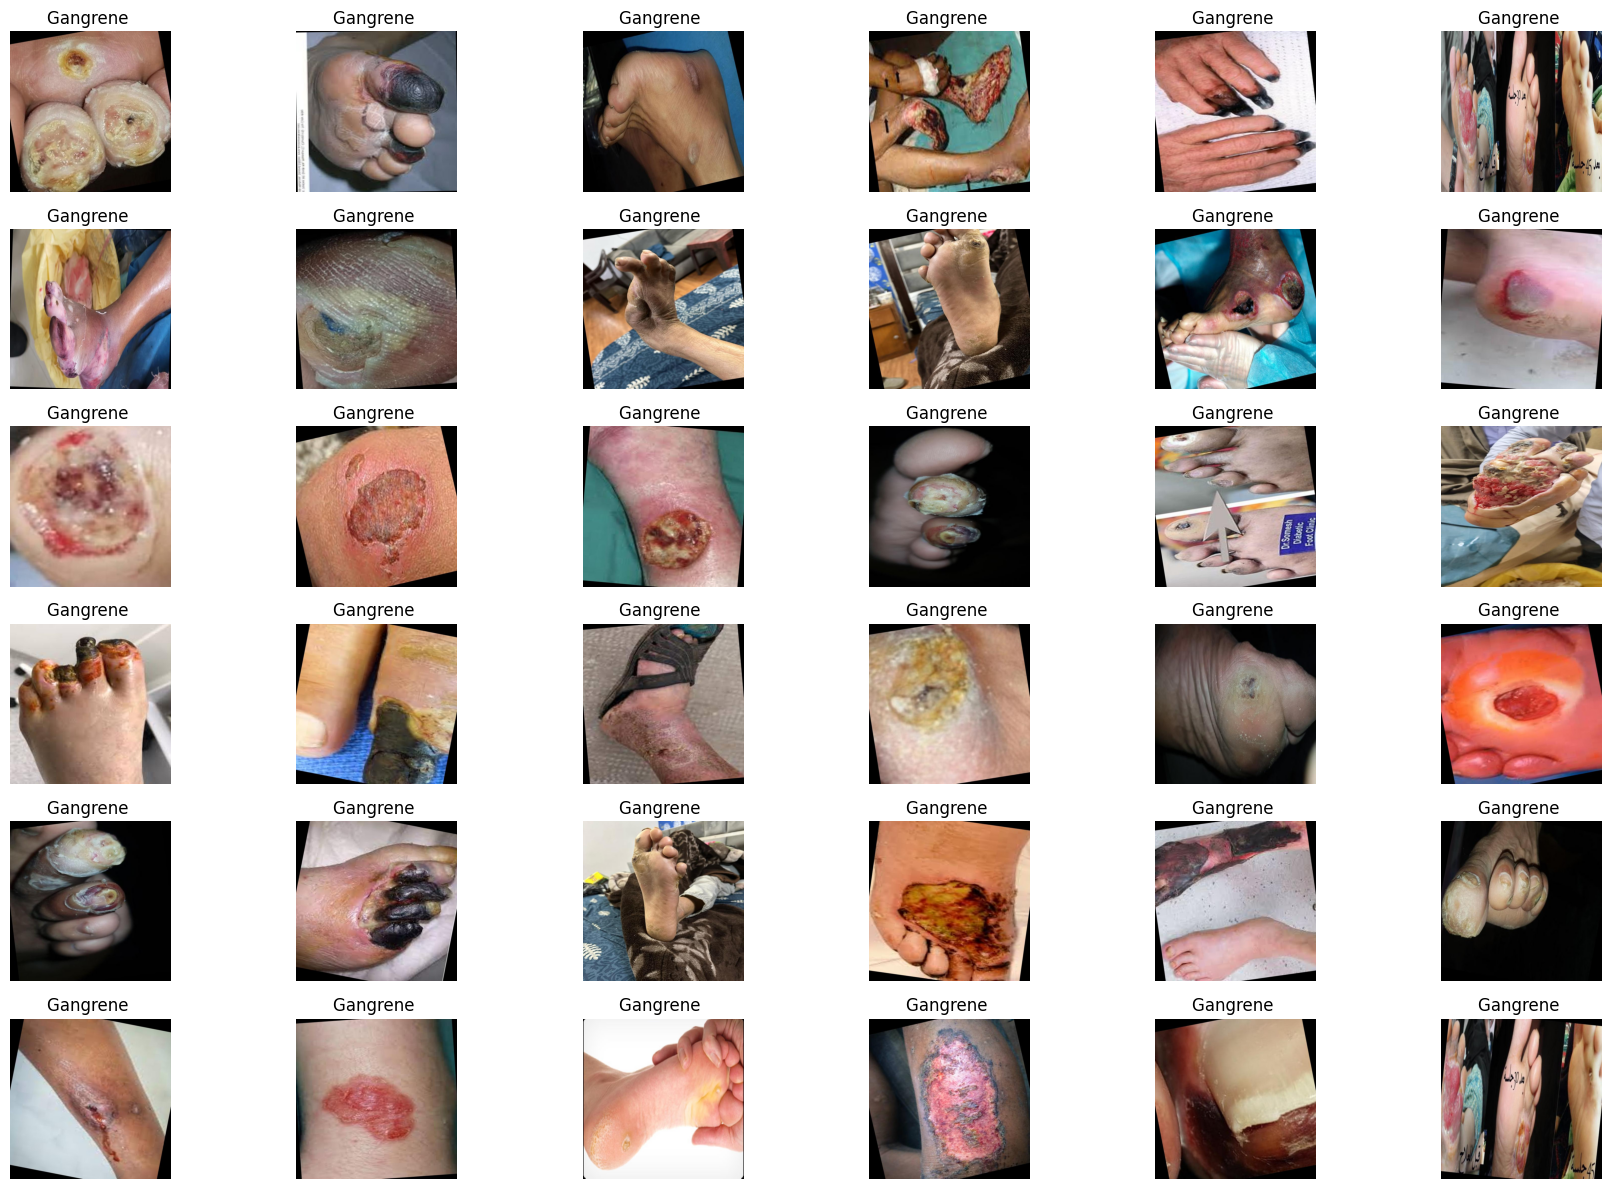

Found 1115 images belonging to 2 classes.
Found 790 images belonging to 2 classes.
Found 708 images belonging to 2 classes.


In [ ]:
# Define the image file paths
images = training_images

# Define the corresponding categories for each image
categories = [img.split(os.sep)[-2] for img in images]

plt.figure(figsize=(18, 12))
for i in range(min(36, len(images))):
    img = plt.imread(images[i])
    plt.subplot(6, 6, i + 1)
    plt.imshow(img)
    plt.title(categories[i])  # Display the category in the title
    plt.axis("off")
plt.tight_layout()
plt.show()

# Create data generators
batch_size = 47
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,

)

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes,

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    classes=classes
)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Define the number of classes
num_classes = len(classes)

# Build the EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Unfreeze the last 20 layers of the base model
#for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
 #   layer.trainable = True

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),      # Batch Normalization Layer
    layers.Dropout(0.4),              # Dropout layer for regularization
    layers.Dense(num_classes, activation='softmax')  # Final layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)


Epoch 1/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.5127 - loss: 4.5428 - val_accuracy: 0.2025 - val_loss: 4.2945 - learning_rate: 1.0000e-04
Epoch 2/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.5209 - loss: 4.2396 - val_accuracy: 0.7975 - val_loss: 3.9944 - learning_rate: 1.0000e-04
Epoch 3/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.5026 - loss: 3.9644 - val_accuracy: 0.2025 - val_loss: 3.7643 - learning_rate: 1.0000e-04
Epoch 4/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.5025 - loss: 3.7028 - val_accuracy: 0.2025 - val_loss: 3.5427 - learning_rate: 1.0000e-04
Epoch 5/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.5092 - loss: 3.5052 - val_accuracy: 0.2025 - val_loss: 3.3452 - learning_rate: 1.0000e-04
Epoch 6/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.5276 - loss: 3.2798 - val_accuracy: 0.7975 - val_loss: 3.1115 - learning_rate: 1.0000e-04
Epoch 7/11
35/35 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.5000 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

           Gangrene        0.89      1.00      0.94       628
Acanthosis Nigricans       0.00      0.00      0.00        80

            accuracy                           0.89       708
           macro avg       0.44      0.50      0.47       708
        weighted avg       0.79      0.89      0.83       708



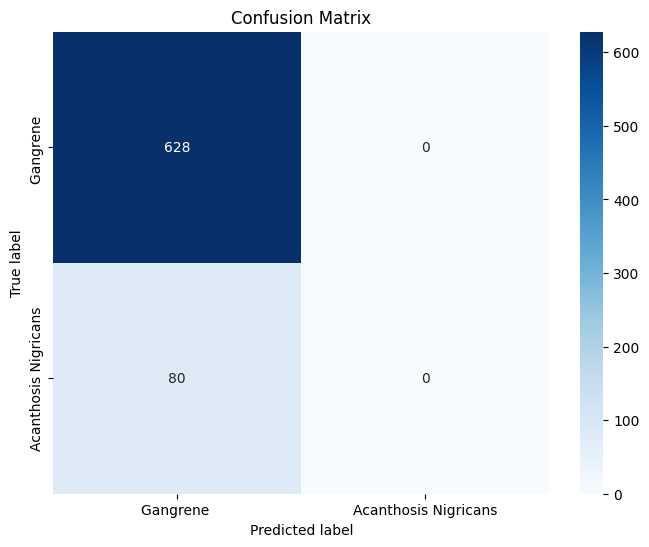

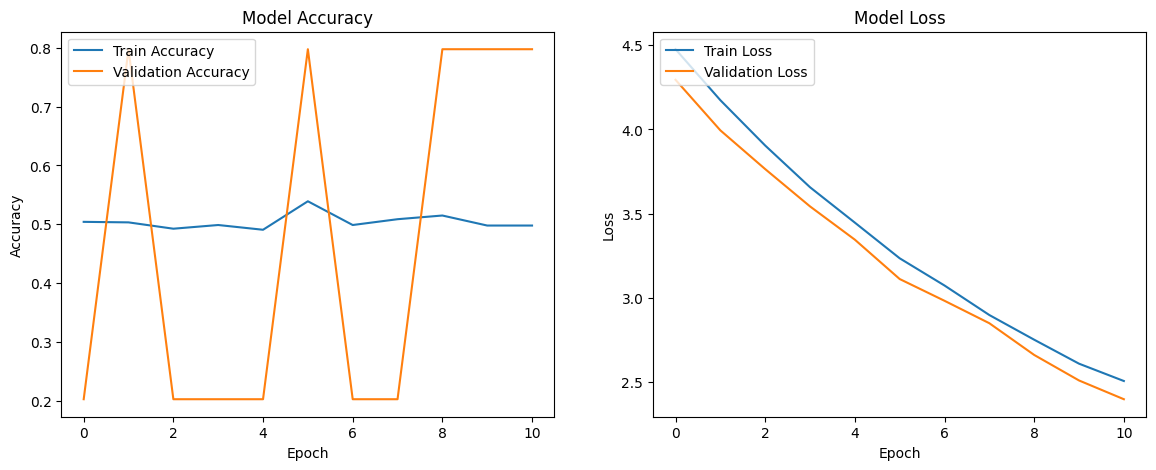

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=11,  # Set the number of epochs as needed
    batch_size=47,
    callbacks=[early_stopping, checkpoint,reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # Get the true labels

# Generate a classification report
target_names = test_generator.class_indices.keys()  # Get the class names
print(classification_report(y_true, y_pred, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [ ]:
#
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Make predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predictions to class labels
y_true = test_generator.classes  # Get the true labels

# Generate a classification report
target_names = test_generator.class_indices.keys()  # Get the class names
print(classification_report(y_true, y_pred, target_names=target_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()





#








# Train the model with the modified settings
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1,
    steps_per_epoch=len(train_generator),          # Total batches per epoch
    validation_steps=len(validation_generator)      # Total batches per validation epoch
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(
    test_generator,
    verbose=1,
    steps=len(test_generator)                      # Total batches in test set
)
print(f"Test accuracy: {test_acc:.2%}")

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2%}")

# Plot confusion matrix
y_pred = model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation metrics
def tr_plot(history, idx):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'][idx:])
    plt.plot(history.history['val_accuracy'][idx:])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'][idx:])
    plt.plot(history.history['val_loss'][idx:])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Calculate accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2%}")

# Print message
subject = 'nails'
acc = test_acc * 100
msg = f'Accuracy on the test set is {acc:5.2f}%'
print(msg)


# Save the model
model.save('image_classification_model2.h5')